In [146]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [147]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33

g_a_g_v=1.297 #ratio of vector and axial coupling constants

Функция для расчета порога реакции

In [148]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [149]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [150]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [151]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [152]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [153]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

E_x до 5 МэВ!!!

In [154]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [155]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10

In [156]:
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1

### BS05_OP flux

In [157]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


создаем словарь, где ключ - название канала нейтрино (напр O или F), значение - двумерный массив, характеризующий интеполированные значения энергии и амплитуды для даннаго канала нейтрино 

In [158]:
all_fluxes_step = 0.01
Energy_all_fluxes = np.arange(0,20,0.01) #массив характеризующий шаги интегрирования

In [159]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

### Cross-section and total rate

### Расчет сечения с учетом только дискретных уровней 

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [160]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [161]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [162]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma):
    
    const = 1.597*math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    for elem in list(BS05_OP_dict.keys()):
        rate = sum(BS05_OP_dict[elem]*sigma_total*all_fluxes_step) * math.pow(10,36)
        print(elem, ' ', rate)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

    Считаем свертку потока с сечением. 
    BS05_OP_dict[elem] - массив со значениями амплитуды потока нейтрино для канала elem.
    sigma - массив со значениями суммарного сечения.
    all_fluxes_step - шаг интегрирования.
    math.pow(10,36) - для получения итогового значения в SNU. 

In [163]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                  for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

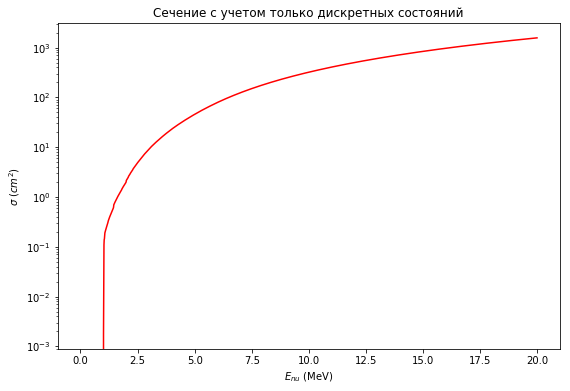

In [164]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.title('Сечение с учетом только дискретных состояний')

In [165]:
rate_calc(sigma_less5)

hep   0.0451063572066
F   0.0210597366245
B   13.5423079221
pp   0.0
O   0.827549244942
N   0.101981181764


### Расчет сечения с учетом только GTR
GTR в виде гауссовского пика

In [166]:
def gauss(x, mu, sigma, k):
    y = k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Параметры взяты из декомпозиции

In [167]:
mu = 11.05338743
sigma = 2.04836474
k = 1.40655398

In [168]:
x_norm = np.arange(0, 28, 0.5)
y_norm = gauss(x_norm, mu, sigma, k)
trapz(y_norm, x_norm)

7.2219300000000004

B(GT) = 0.86 x 3(N-Z) = 0.86 x 36 = 30.96. Отнормируем гаусс

In [169]:
y_norm = y_norm/trapz(y_norm, x_norm)*30.96
trapz(y_norm, x_norm)

30.960000000000001

Сечение для непрерывной части

$\sigma = {(1.597\times10^{-44}\ cm^2)} \int^{z-Q}_{0} {(\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [170]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy*np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [171]:
#разбиваем интервал интегрирования насубинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [172]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

In [173]:
p_list = np.arange(0,20, 0.1) #p = z - Q

#sigma_more5_temp = [ quad(sigma_k_more5, 0, p, args=(p), limit=200)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.fixed_quad(sigma_k_more5, 0, p, args=(p, x_norm, y_norm), n=20)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.romberg(sigma_k_more5, 0, p, args=(p,)) for p in p_list]
#sigma_more5_temp = [sigma_more5_ab(p) for p in p_list]

sigma_GTR_temp = [cross_sec(0,p, sigma_k_GTR, x_norm, y_norm, 200) for p in p_list]

sigma_GTR = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

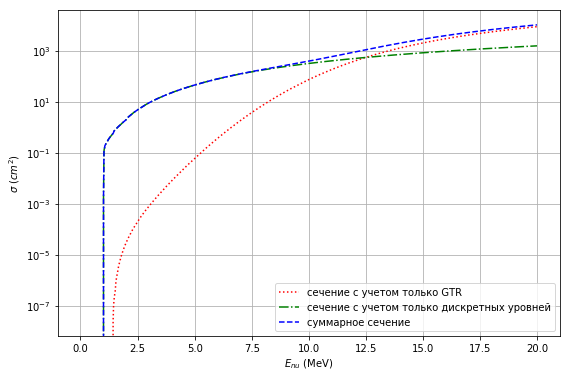

In [174]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_GTR, ls=':', c='r', label='сечение с учетом только GTR')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='сечение с учетом только дискретных уровней')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR, ls='--', c='b', label='суммарное сечение')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.legend()
plt.grid()
#plt.title('Сечение с учетом только дискретных состояний')

In [175]:
rate_calc(sigma_less5+sigma_GTR)

hep   0.106784818915
F   0.0210597497311
B   17.2700845893
pp   0.0
O   0.827549731249
N   0.101981181764


Немного технической работы для перепроверки на маткаде

In [176]:
GTR_df = pd.DataFrame({'x':x_norm, 'y':y_norm})
GTR_df.to_csv('gtr_influence/GTR.csv', sep=';')

In [177]:
sigma_GTR_df = pd.DataFrame({'Energy':Energy_all_fluxes, 'cross sec':sigma_GTR})
sigma_GTR_df.to_csv('gtr_influence/sigma_GTR.csv', sep=';')

In [178]:
Energy_all_fluxes_short = np.arange(0, 20, 0.5)
sigma_GTR_short_df = pd.DataFrame({'Energy':Energy_all_fluxes_short,
                                     'cross sec':np.interp(Energy_all_fluxes_short, xp=Energy_all_fluxes, fp=sigma_GTR)})

sigma_GTR_short_df.to_csv('gtr_influence/sigma_GTR_short.csv', sep=';')

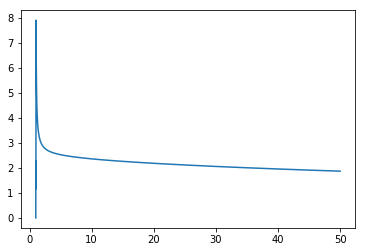

In [179]:
#fermi_func_df = pd.DataFrame({'Energy in m_e units':Energy_all_fluxes, 
#                              'f_value':num_tables_func(Energy_all_fluxes)})
#fermi_func_df.to_csv('gtr_influence/fermi_func.csv', sep=',')
fermi_func_df = pd.DataFrame({'Energy in m_e units':e_e3, 'f_value':Fermi_func_new_data['F0L0'].values})
fermi_func_df.to_csv('gtr_influence/fermi_func.csv', sep=';')

#a=num_tables_func(Energy_all_fluxes)
plt.plot(fermi_func_df['Energy in m_e units'], fermi_func_df['f_value'])

### Расчет сечения с учетом только IAS
IAS в виде гауссовского пика, параметры взяты из декомпозиции

0.97211298999946127

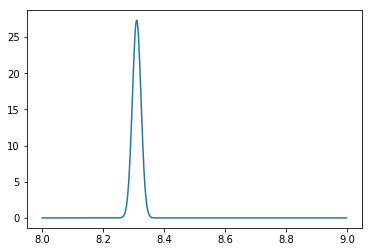

In [180]:
m_IAS = 8.31025152e+00
s_IAS = -1.41850172e-02
k_IAS = 2.73399015e+01

x_IAS = np.arange(8, 9, 0.001)
y_IAS = gauss(x_IAS, m_IAS, s_IAS, k_IAS)

plt.plot(x_IAS, y_IAS)
trapz(y_IAS, x_IAS)

IAS
0.86 x (N-Z) = 0.86 x 12 = 10.32. Нормируем 

In [181]:
y_IAS = y_IAS/trapz(y_IAS, x_IAS)*10.32
trapz(y_IAS, x_IAS)

10.32

Сечение для непрерывной части

$\sigma = {(1.597\times10^{-44}\ cm^2)} \int^{z-Q}_{0} {\sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{IAS}(x) \cdot F(z-Q-x+0.511)} dx $ 

In [182]:
def sigma_k_IAS(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return np.sqrt(e_energy**2-m_e_square)*e_energy*np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [183]:

#sigma_IAS_temp = [ quad(sigma_k_IAS, 8.2, 8.4, args=(p, x_IAS, y_IAS), limit=200)[0] for p in p_list]
#sigma_IAS_temp = [ sc.integrate.fixed_quad(sigma_k_IAS, 8, p, args=(p, x_IAS, y_IAS), n=20)[0] for p in p_list]
#sigma_IAS_temp = [ sc.integrate.romberg(sigma_k_IAS, 8, p, args=(p, x_IAS, y_IAS)) for p in p_list]

sigma_IAS_temp = [cross_sec(0,p, sigma_k_IAS, x_IAS, y_IAS, 200) for p in p_list]

sigma_IAS = np.interp(Energy_all_fluxes, xp=p_list_1+Q_EC_76As, fp=sigma_IAS_temp)

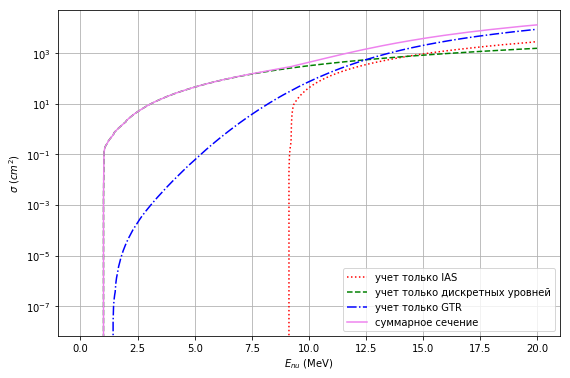

In [184]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_IAS, c='r', ls=':', label='учет только IAS')
plt.plot(Energy_all_fluxes, sigma_less5, c='g', ls='--', label='учет только дискретных уровней')
plt.plot(Energy_all_fluxes, sigma_GTR, c='b', ls='-.', label='учет только GTR')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR+sigma_IAS, c='violet', label='суммарное сечение')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.grid()
plt.legend()
#plt.title('Сечение с учетом только дискретных состояний')

In [185]:
rate_calc(sigma_less5+sigma_GTR+sigma_IAS1)

hep   0.136543101181
F   0.0210597497311
B   19.4609691809
pp   0.0
O   0.827549731249
N   0.101981181764
